In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import ppscore as pps
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from feature_engine import categorical_encoders as ce

warnings.simplefilter("ignore")
%matplotlib inline

Steps: 
- Natural Log Normalize House Price -> then turn back after prediction
- Combine temporal variables (remove garage as it can be detected from hasGarage)
- Missing Values -> Fill with Missing, except for PoolQC, Alley etc change to binary
- Categorical to dummy variables

In [2]:
train = pd.read_csv("../data/train.csv", index_col = [0])
test = pd.read_csv("../data/test.csv", index_col = [0])

In [3]:
temporal = [var for var in train.columns if ("Yr" in var) 
        or ("Mo" in var) or ("Year" in var)]

levels = ["OverallCond", "OverallQual", "MSSubClass", "BsmtFullBath", 
            "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", 
            "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars",
            "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 
            "BsmtExposure", "HeatingQC", "KitchenQual", 
          "GarageQual","GarageCond", "ExterQual",
         "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure",
          "HeatingQC", "PoolQC", "KitchenQual", "GarageQual",
          "GarageCond", "FireplaceQu"]

categorical = [var for var in train.columns if (train[var].dtype =='O') 
               and (var not in temporal)
              and (var not in levels)]

numerical = [var for var in train.columns if (train[var].dtype !='O') 
             and (var not in temporal) 
             and (var not in levels)]
numerical_level = levels + numerical

In [4]:
## categorical to levels conversion
train["ExterQual"] = train["ExterQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["ExterCond"] = train["ExterCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtQual"] = train["BsmtQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtCond"] = train["BsmtCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtExposure"] = train["BsmtExposure"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["HeatingQC"] = train["HeatingQC"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["PoolQC"] = train["PoolQC"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["KitchenQual"] = train["KitchenQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["GarageQual"] = train["GarageQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["GarageCond"] = train["GarageCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["FireplaceQu"] = train["FireplaceQu"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

## Train Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train, train["SalePrice"], 
                                                    test_size=0.25, 
                                                    random_state=100)

## Normalize Sale Price

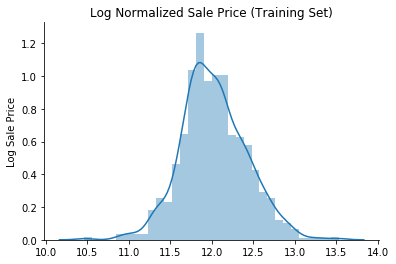

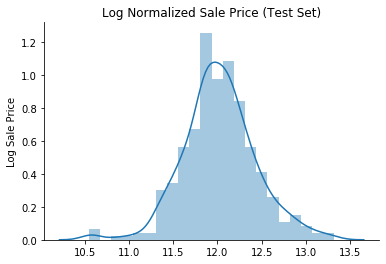

In [6]:
y_label = np.log(X_train[["SalePrice"]])

sns.distplot(y_label)
plt.title("Log Normalized Sale Price (Training Set)")
plt.ylabel("Log Sale Price")
sns.despine()
plt.show()

y_label = np.log(X_test[["SalePrice"]])

sns.distplot(y_label)
plt.title("Log Normalized Sale Price (Test Set)")
plt.ylabel("Log Sale Price")
sns.despine()
plt.show()

## Combine Temporal

In [7]:
def combine_temporal(X_train, X_test):
    X_train["n_temp_houseAge"] = \
    X_train["YrSold"] - X_train["YearBuilt"]
    X_train["n_temp_lastRemodelled"] = \
    X_train["YrSold"] - X_train["YearRemodAdd"]
    X_train["n_temp_garageAge"] = \
    X_train["YrSold"] - X_train["GarageYrBlt"]
    
    X_test["n_temp_houseAge"] = \
    X_test["YrSold"] - X_test["YearBuilt"]
    X_test["n_temp_lastRemodelled"] = \
    X_test["YrSold"] - X_test["YearRemodAdd"]
    X_test["n_temp_garageAge"] = \
    X_test["YrSold"] - X_test["GarageYrBlt"]
    
    cols = ["YrSold",
           "YearBuilt",
           "YearRemodAdd",
            "GarageYrBlt"]
    
    return X_train.drop(cols, axis = 1), X_test.drop(cols, axis = 1)

def fill_with_median(X_train, X_test, variable):
    median = X_train[variable].median()
    X_train[variable] = X_train[variable].fillna(median)
    X_test[variable] = X_test[variable].fillna(median)
    return X_train, X_test

In [8]:
X_train, X_test = combine_temporal(X_train, X_test)
X_train, X_test = fill_with_median(X_train, X_test, "n_temp_garageAge")

## Missing Values

### Continuous & Levels

In [9]:
def fill_zero(X_train, X_test, variable):
    X_train[variable] = X_train[variable].fillna(0)
    X_test[variable] = X_test[variable].fillna(0)
    return X_train, X_test

In [10]:
X_train, X_test = fill_zero(X_train, X_test, numerical + levels)

### Categorical

In [15]:
def fill_with_missing(X_train, X_test, variable):
    X_train[variable] = X_train[variable].fillna("Missing")
    X_test[variable] = X_test[variable].fillna("Missing")
    return X_train, X_test

def fill_with_mode_from_train(X_train, X_test, variable):
    mode = X_train[variable].mode().iloc[0]
    X_train[variable] = X_train[variable].fillna(mode)
    X_test[variable] = X_test[variable].fillna(mode)
    return X_train, X_test

In [16]:
X_train, X_test = fill_with_missing(X_train, 
                                    X_test,
                                    ["Alley", "MasVnrType", 
                                     "BsmtFinType1", "BsmtFinType2", 
                                     "GarageType", "GarageFinish", 
                                     "Fence", "MiscFeature"]
                                   )
X_train, X_test = fill_with_mode_from_train(X_train, 
                                            X_test, 
                                            ["Electrical"])

## Rare Labels

In [17]:
def find_non_rare_labels(df, variable, tolerance):
    temp = df.groupby([variable])[variable].count()/len(df)
    non_rare = [x for x in temp.loc[temp > tolerance].index.values]
    return non_rare

def rare_encoding(X_train, X_test, variable, tolerance):
    X_train = X_train.copy()
    X_test = X_test.copy()
    frequent_cat = find_non_rare_labels(X_train, variable, tolerance)
    X_train[variable] = np.where(X_train[variable].isin(
        frequent_cat), X_train[variable], 'Rare')
    X_test[variable] = np.where(X_test[variable].isin(
        frequent_cat), X_test[variable], 'Rare')
    return X_train, X_test

In [18]:
for variable in categorical:
    if len(X_train[variable].unique()) > 5:
        print(variable)
        X_train, X_test = rare_encoding(X_train, 
                                        X_test, 
                                        variable, 0.05)

Neighborhood
Condition1
Condition2
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
Foundation
BsmtFinType1
BsmtFinType2
Heating
Functional
GarageType
SaleType
SaleCondition


## Dummy Categorical Variables

In [35]:
def one_hot_encoding(X_train, X_test, variable):

    encoder = ce.OneHotCategoricalEncoder(
        top_categories = None,
        variables = categorical,
        drop_last = True)
    encoder.fit(X_train)
    
    return encoder.transform(X_train), encoder.transform(X_test)

In [37]:
X_train, X_test = one_hot_encoding(X_train, X_test, categorical)

## Combining Everything

In [11]:
def shape_data(train):
    temporal = [var for var in train.columns if ("Yr" in var) 
            or ("Mo" in var) or ("Year" in var)]

    levels = ["OverallCond", "OverallQual", "MSSubClass", "BsmtFullBath", 
              "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", 
              "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars",
            "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC",
             "KitchenQual", "GarageQual", "GarageCond"]

    categorical = [var for var in train.columns 
                   if (train[var].dtype =='O') 
                   and (var not in temporal)
                  and (var not in levels)]

    numerical = [var for var in train.columns 
                 if (train[var].dtype !='O') 
                 and (var not in temporal) 
                 and (var not in levels)]
    numerical_level = levels + numerical
    
    ## categorical to levels conversion
    train["ExterQual"] = train["ExterQual"].map({"None":0,"Po":1, 
                                                 "Fa":2, "TA":3, 
                                                 "Gd":4, "Ex":5})
    train["ExterCond"] = train["ExterCond"].map({"None":0,"Po":1, 
                                                 "Fa":2, "TA":3, 
                                                 "Gd":4, "Ex":5})
    train["BsmtQual"] = train["BsmtQual"].map({"None":0,"Po":1, 
                                               "Fa":2, "TA":3, 
                                               "Gd":4, "Ex":5})
    train["BsmtCond"] = train["BsmtCond"].map({"None":0,"Po":1, 
                                               "Fa":2, "TA":3, 
                                               "Gd":4, "Ex":5})
    train["BsmtExposure"] = train["BsmtExposure"].map({"None":0,"Po":1, 
                                                       "Fa":2, "TA":3, 
                                                       "Gd":4, "Ex":5})
    train["HeatingQC"] = train["HeatingQC"].map({"None":0,"Po":1, 
                                                 "Fa":2, "TA":3, 
                                                 "Gd":4, "Ex":5})
    train["KitchenQual"] = train["KitchenQual"].map({"None":0,"Po":1, 
                                                     "Fa":2, "TA":3, 
                                                     "Gd":4, "Ex":5})
    train["GarageQual"] = train["GarageQual"].map({"None":0,"Po":1, 
                                                   "Fa":2, "TA":3, 
                                                   "Gd":4, "Ex":5})
    train["GarageCond"] = train["GarageCond"].map({"None":0,"Po":1, 
                                                   "Fa":2, "TA":3, 
                                                   "Gd":4, "Ex":5})
    ## label
    try:
        label_train = pd.DataFrame()
        label_train["log_SalePrice"] = np.log(train["SalePrice"])
        label_train["SalePrice"] = train["SalePrice"]
    except:
        pass
    
    ## temporal data
    temporal_train = pd.DataFrame()
    temporal_train["n_temp_houseAge"] = \
        train["YrSold"] - train["YearBuilt"]
    temporal_train["n_temp_lastRemodelled"] = \
        train["YrSold"] - train["YearRemodAdd"]
    
    ## numerical data
    numerical_train = train[numerical].fillna(0)
    
    ## ranked data
    levels_train = train[levels].fillna(0)
    
    ## categorical data
    categorical_train = train[categorical].copy()
    cat1 = ["Alley", "MasVnrType", "BsmtFinType1", 
            "BsmtFinType2", "FireplaceQu", 
            "GarageType", "GarageFinish", 
            "PoolQC", "Fence", "MiscFeature"]
    categorical_train[cat1] = categorical_train[cat1].fillna("Missing")
    categorical_train["Electrical"] = \
    categorical_train["Electrical"].fillna(
        categorical_train["Electrical"].mode().iloc[0])
    
    dummy_categorical_train = pd.get_dummies(categorical_train, drop_first= True)
    
    train_results = pd.concat([temporal_train, 
                               numerical_train.drop("SalePrice", axis = 1), 
                               levels_train, 
                               dummy_categorical_train, 
                               label_train], axis = 1)
    return train_results

In [18]:
basic_feature_engineered_results = shape_data(train)

In [19]:
basic_feature_engineered_results.to_csv(
    "../data/basic_feature_engineered_training_data.csv")

### Further Feature Engineering

In [28]:
train = basic_feature_engineered_results.copy()

#### 1. Continuous Variable

In [35]:
### Annotate Variable with distinct outliers

In [69]:
train["has_3SsnPorch"] = np.where(
    train["3SsnPorch"] == 0, 0, 1)
train["has_ScreenPorch"] = np.where(
    train["ScreenPorch"] == 0, 0, 1)
train["has_Pool"] = np.where(
    train["PoolArea"] == 0, 0, 1)
train["has_ScreenPorch"] = np.where(
    train["3SsnPorch"] == 0, 0, 1)
train["has_EnclosedScreenPorch"] = np.where(
    train["EnclosedPorch"] == 0, 0, 1)
train["has_miscVal"] = np.where(
    train["MiscVal"] == 0, 0, 1)
train["has_LowQualFin"] = np.where(
    train["LowQualFinSF"] == 0, 0, 1)

In [70]:
# drop feature that is an interaction to each other
drop_cont = ["BsmtFinSF1", "BsmtFinSF2"]

Will use scaler on training data and test set, will not be done on the whole feature to not have any data leakage. Other than that, very skewed distribution, and non-equal variance data will be set into binary variables. (high skew, high kurtosis)

#### 2. Ranked Variable

In [77]:
## fix the ranking groups (make it smaller) 
##if it is too low less 
## than 2% of population, include with other groups to 
## create monotonic relationship